#### In this jupyter notebook, I made 80 clusters for all local business with the convenience score calculated by Izzy as weight
#### And I created coverage area based on the cluster centers I generated

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import geopandas as gpd

In [2]:
# Import dataset that contains convenience score - the weight column (Izzy made the file)
hilo_business = pd.read_csv("../data/hilo_dist_detail.csv")
hilo_business

,Unnamed: 0,Name,Address,Coordinates,Lat,Long,fast_food,user_ratings_total,bakery,cafe,meal_delivery,meal_takeaway,restaurant,food,hours_open,weight
0,0,Hilo Bay Medical Clinic,"24 Pukihae Street, Hilo",POINT (-155.0879458 19.7301366),19.730137,-155.087946,0,1.000000,0,1,0,1,0,0,NaN,6.952381
1,1,Wild Ginger Hotel,"100 Puueo Street, Hilo",POINT (-155.0891752 19.7293163),19.729316,-155.089175,0,0.082481,0,1,0,1,0,0,NaN,7.082481
2,2,Dolphin Bay Hotel,"333 Iliahi Street, Hilo",POINT (-155.0904265 19.7292288),19.729229,-155.090427,0,0.061332,0,1,0,1,0,0,NaN,6.013713
3,3,Hilo Bay Oceanfront Bed and Breakfast,"56 Pukihae Street, Hilo",POINT (-155.0881646 19.7309761),19.730976,-155.088165,0,0.021149,0,1,0,1,0,0,NaN,7.021149
4,4,11 Arruda Ln.,Hilo,POINT (-155.08903 19.728593),19.728593,-155.089030,0,1.000000,0,1,0,1,0,0,NaN,6.952381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,640,College Hall B,Hilo,POINT (-155.0798863 19.7032682),19.703268,-155.079886,0,1.000000,0,1,0,1,0,0,NaN,6.952381
641,641,Kealoha Beach Park,"1701 Kalanianaole Ave Hilo, HI 96720",POINT (-155.033601628064 19.7351520340121),19.735152,-155.033602,0,1.000000,0,1,0,1,0,0,NaN,6.952381
642,642,Liko Lehua Cafe,"177 Kaumana Dr Hilo, HI 96720",POINT (-155.10633 19.71326),19.713260,-155.106330,0,1.000000,0,1,0,1,0,0,NaN,6.952381
643,643,Shell,"394 Kamehameha Avenue, Hilo",POINT (-155.0840452 19.723121),19.723121,-155.084045,0,0.013042,0,1,0,1,0,1,NaN,9.179709


In [3]:
# Clean all rows that do not have a valid coordinate
hilo_business = hilo_business[hilo_business["Coordinates"].notnull()]

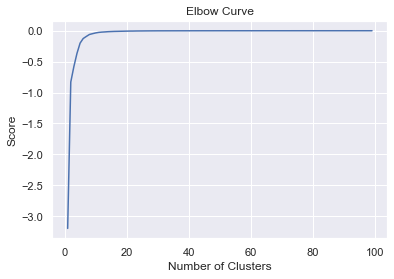

In [48]:
# Create an elbow plot to help us determine k
K_clusters = range(1,100)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = hilo_business[['Lat']]
X_axis = hilo_business[['Long']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the plot, we can see any clusters larger than ~10 will have similar score. Therefore, we can use cluster number larger than 10.
I choose 80 clusters here.

In [4]:
# Perform kmean with 80 clusters with weight (convenience score)
kmeans = KMeans(n_clusters = 80, init ='k-means++')
kmeans.fit(hilo_business[["Lat","Long"]], sample_weight = hilo_business["weight"]) # Compute k-means clustering.
hilo_business['cluster_label'] = kmeans.fit_predict(hilo_business[["Lat","Long"]],sample_weight = hilo_business["weight"])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(hilo_business[["Lat","Long"]],sample_weight = hilo_business["weight"]) # Labels of each point
hilo_business = hilo_business.iloc[:,1:]
hilo_business.head(10)

,Name,Address,Coordinates,Lat,Long,fast_food,user_ratings_total,bakery,cafe,meal_delivery,meal_takeaway,restaurant,food,hours_open,weight,cluster_label
0,Hilo Bay Medical Clinic,"24 Pukihae Street, Hilo",POINT (-155.0879458 19.7301366),19.730137,-155.087946,0,1.000000,0,1,0,1,0,0,NaN,6.952381,4
1,Wild Ginger Hotel,"100 Puueo Street, Hilo",POINT (-155.0891752 19.7293163),19.729316,-155.089175,0,0.082481,0,1,0,1,0,0,NaN,7.082481,4
2,Dolphin Bay Hotel,"333 Iliahi Street, Hilo",POINT (-155.0904265 19.7292288),19.729229,-155.090427,0,0.061332,0,1,0,1,0,0,NaN,6.013713,4
3,Hilo Bay Oceanfront Bed and Breakfast,"56 Pukihae Street, Hilo",POINT (-155.0881646 19.7309761),19.730976,-155.088165,0,0.021149,0,1,0,1,0,0,NaN,7.021149,4
4,11 Arruda Ln.,Hilo,POINT (-155.08903 19.728593),19.728593,-155.089030,0,1.000000,0,1,0,1,0,0,NaN,6.952381,4
5,JUMPSTART PRESCHOOL,"317 Lehua Street, Hilo",POINT (-155.0903387 19.7301202),19.730120,-155.090339,0,1.000000,0,1,0,1,0,0,NaN,6.595238,4
6,Puueo Cluster Head start,"145 Wainaku Street, Hilo",POINT (-155.0913683 19.7283575),19.728358,-155.091368,0,1.000000,0,1,0,1,0,0,NaN,6.952381,4
7,Piihonua 4 Early Childhood,Hilo,POINT (-155.0900154 19.7297152),19.729715,-155.090015,0,1.000000,0,1,0,1,0,0,NaN,6.952381,4
8,Moon and Turtle,"51 Kalakaua Street, Hilo",POINT (-155.0871554 19.7254179),19.725418,-155.087155,0,0.144519,0,1,0,1,1,1,NaN,9.852852,65
9,Cronies Bar & Grill,"11 Waianuenue Avenue, Hilo",POINT (-155.0868843 19.7264366),19.726437,-155.086884,0,0.286218,0,1,0,1,1,1,NaN,10.524313,65


In [5]:
# Transform the business dataset with cluster labels to geodataframe for geojson generating
hilo_business_gdf = gpd.GeoDataFrame(
    hilo_business, geometry=gpd.points_from_xy(hilo_business.Long, hilo_business.Lat, crs='epsg:4326'),crs=4326) 

In [6]:
# Transform the 80 cluster centers to geodataframe for geojson generating
center_df_org = pd.DataFrame(centers, columns = ['lat','long'])
center_gdf_p = gpd.GeoDataFrame(
    center_df_org, geometry=gpd.points_from_xy(center_df_org.long, center_df_org.lat, crs='epsg:4326'),crs=4326) 
# Create a buffer zone. In Hilo, 0.0037° is approximately 1/4 mile, which is 5-min walking distance
buffer = center_gdf_p.buffer(0.0037)

C:\Users\Charlie Qiu\AppData\Local\Temp\ipykernel_62280\3961786828.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = center_gdf_p.buffer(0.0037)


In [7]:
# Create geodataframe for 80 buffer zone for geojson generating
center_gdf_buffer = gpd.GeoDataFrame(
    center_gdf_p, geometry=buffer,crs=4326)
center_gdf_buffer

,lat,long,geometry
0,19.694360,-155.065963,"POLYGON ((-155.06226 19.69436, -155.06228 19.6..."
1,19.503702,-154.956332,"POLYGON ((-154.95263 19.50370, -154.95265 19.5..."
2,19.691433,-156.018892,"POLYGON ((-156.01519 19.69143, -156.01521 19.6..."
3,19.049458,-155.662554,"POLYGON ((-155.65885 19.04946, -155.65887 19.0..."
4,19.729414,-155.089298,"POLYGON ((-155.08560 19.72941, -155.08562 19.7..."
...,...,...,...
75,19.675455,-155.075656,"POLYGON ((-155.07196 19.67546, -155.07197 19.6..."
76,19.716551,-155.077734,"POLYGON ((-155.07403 19.71655, -155.07405 19.7..."
77,19.697958,-155.063110,"POLYGON ((-155.05941 19.69796, -155.05943 19.6..."
78,19.702606,-155.079334,"POLYGON ((-155.07563 19.70261, -155.07565 19.7..."


In [8]:
# Extract locations with higher business density
no_outlier_index = hilo_business_gdf[hilo_business_gdf["Lat"]>19.665][hilo_business_gdf["Long"]>-155.15][hilo_business_gdf["Long"]<-155.02][hilo_business_gdf["Lat"]<19.75].cluster_label.unique()

d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [9]:
# Extract on locations with higher business density
recluster = hilo_business_gdf[hilo_business_gdf["Lat"]>19.665][hilo_business_gdf["Long"]>-155.15][hilo_business_gdf["Long"]<-155.02][hilo_business_gdf["Lat"]<19.75]

d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
d:\python\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<AxesSubplot:>

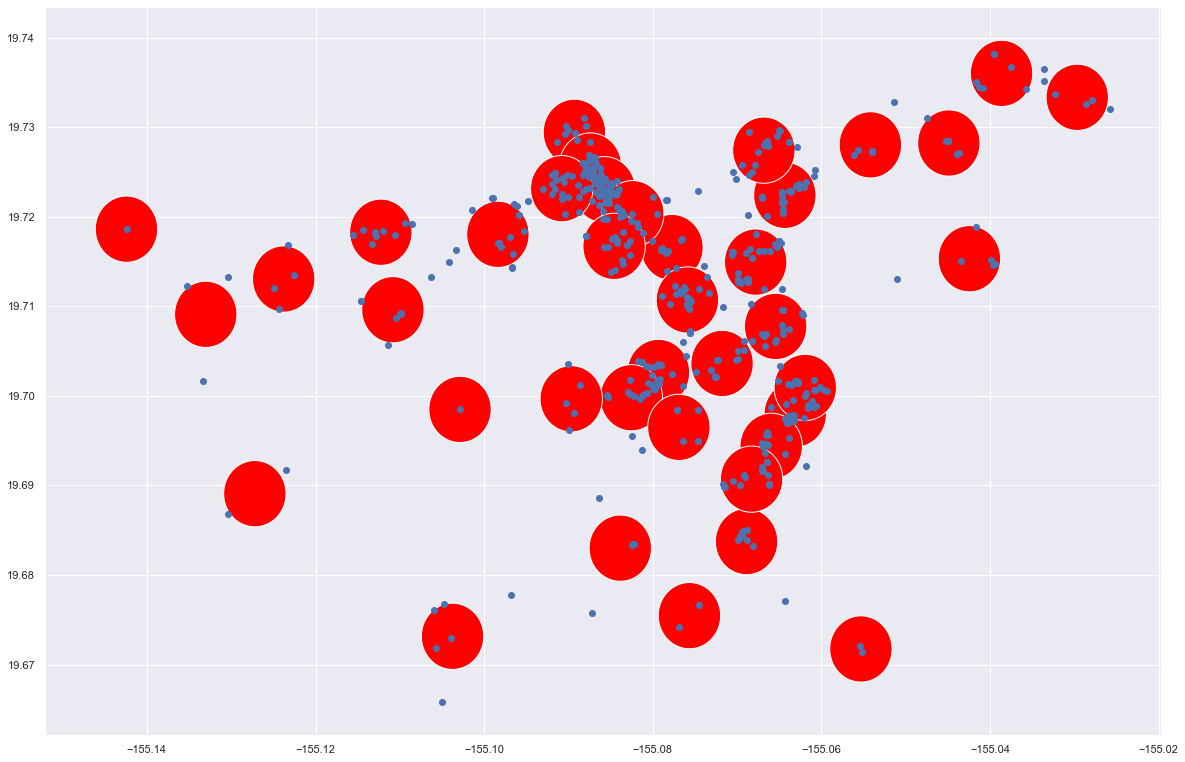

In [10]:
# Plot the region with high business density to see if it is needed to recluster
fig, ax = plt.subplots(figsize=(20, 20))
buffer[no_outlier_index].plot(ax=ax,figsize=(20,20),color="red")
recluster.plot(ax=ax,figsize=(20,20))

Since these regions have high business density, we need to ensure that these regions have good distribution point coverage. Therefore, I decide
to perform a k-mean again for this region

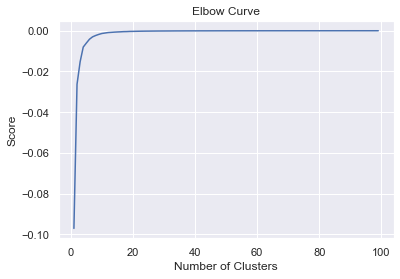

In [56]:
# Recluster, only clustering regions with high business density
# I first create the elbow plot to determine k
K_clusters = range(1,100)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = recluster[['Lat']]
X_axis = recluster[['Long']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the plot, we can see any clusters larger than ~10 will have similar score. Therefore, we can use cluster number larger than 10.
I choose 80 clusters here.

In [11]:
buffer[no_outlier_index].shape

(39,)

The regions that need to be reclustered have 40 clusters, so when performing the recluster algorithm, I will use n_clusters = 39 so that
I will have 80 clusters at last

In [12]:
# Reperform k-mean with 39 clusters in the high-business-density region
kmeans_2 = KMeans(n_clusters = 39, init ='k-means++')
kmeans_2.fit(recluster[["Lat","Long"]], sample_weight = recluster["weight"]) # Compute k-means clustering.
recluster['cluster_label'] = kmeans_2.fit_predict(recluster[["Lat","Long"]], sample_weight = recluster["weight"])
centers_re = kmeans_2.cluster_centers_ # Coordinates of cluster centers.
labels_2 = kmeans_2.predict(recluster[["Lat","Long"]], sample_weight = recluster["weight"]) # Labels of each point
centers_re

array([[  19.7003533 , -155.06180815],
       [  19.70238474, -155.07984715],
       [  19.72636317, -155.08777595],
       [  19.73592399, -155.03941981],
       [  19.71330418, -155.06932116],
       [  19.70960708, -155.11082122],
       [  19.68372444, -155.06888193],
       [  19.68907101, -155.12719285],
       [  19.72256726, -155.06407708],
       [  19.67314866, -155.10374986],
       [  19.71802668, -155.0983723 ],
       [  19.71105717, -155.07608813],
       [  19.71768889, -155.08412286],
       [  19.70561454, -155.06770615],
       [  19.71473133, -155.13602587],
       [  19.71529972, -155.04245771],
       [  19.69647661, -155.07691206],
       [  19.68299021, -155.08385732],
       [  19.72312862, -155.09079892],
       [  19.69426231, -155.06618419],
       [  19.69974923, -155.08854883],
       [  19.67173805, -155.0553217 ],
       [  19.71826025, -155.11225049],
       [  19.72801563, -155.05419891],
       [  19.71846227, -155.07853121],
       [  19.70894059, -1

In [13]:
# Create buffer zone for the newly genereated 39 clusters
center_df_re = pd.DataFrame(centers_re, columns = ['lat','long'])
center_df_gdf = gpd.GeoDataFrame(center_df_re, geometry = gpd.points_from_xy(center_df_re.long, center_df_re.lat, crs='epsg:4326'))
buffer_re = center_df_gdf.buffer(0.0037)

C:\Users\Charlie Qiu\AppData\Local\Temp\ipykernel_62280\4211340532.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer_re = center_df_gdf.buffer(0.0037)


<AxesSubplot:>

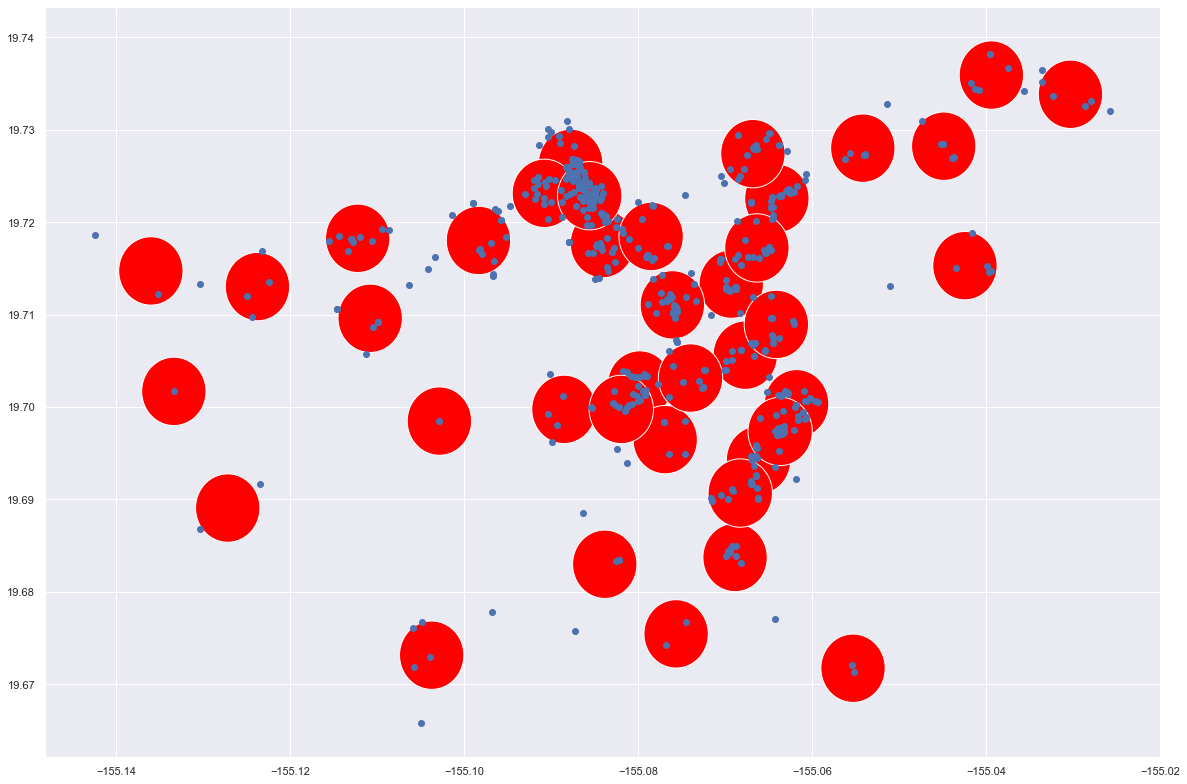

In [14]:
# Visualize the reclustering results
center_gdf_re = gpd.GeoDataFrame(
    center_df_re, geometry=buffer_re,crs=4326) 
fig, ax = plt.subplots(figsize=(20, 20))
center_gdf_re.plot(ax=ax,color="red")
recluster.plot(ax=ax)

In [15]:
# Replace the old 40 cluster centers in the high-business-density region with new 40 centers generated in reclusetering
final_gal = pd.concat([center_gdf_re,center_gdf_buffer.drop(no_outlier_index)])
final_gal

,lat,long,geometry
0,19.700353,-155.061808,"POLYGON ((-155.05811 19.70035, -155.05813 19.6..."
1,19.702385,-155.079847,"POLYGON ((-155.07615 19.70238, -155.07616 19.7..."
2,19.726363,-155.087776,"POLYGON ((-155.08408 19.72636, -155.08409 19.7..."
3,19.735924,-155.039420,"POLYGON ((-155.03572 19.73592, -155.03574 19.7..."
4,19.713304,-155.069321,"POLYGON ((-155.06562 19.71330, -155.06564 19.7..."
...,...,...,...
62,19.660885,-155.128905,"POLYGON ((-155.12520 19.66089, -155.12522 19.6..."
66,19.559889,-154.993350,"POLYGON ((-154.98965 19.55989, -154.98967 19.5..."
67,19.765110,-155.118380,"POLYGON ((-155.11468 19.76511, -155.11470 19.7..."
68,19.733929,-155.014921,"POLYGON ((-155.01122 19.73393, -155.01124 19.7..."


In [16]:
# Create the geodataframe for the cluster centroid of our newest 80 clusters
final_gal_centroid = gpd.GeoDataFrame(final_gal, geometry = gpd.points_from_xy(final_gal.long, final_gal.lat))
final_gal_centroid

,lat,long,geometry
0,19.700353,-155.061808,POINT (-155.06181 19.70035)
1,19.702385,-155.079847,POINT (-155.07985 19.70238)
2,19.726363,-155.087776,POINT (-155.08778 19.72636)
3,19.735924,-155.039420,POINT (-155.03942 19.73592)
4,19.713304,-155.069321,POINT (-155.06932 19.71330)
...,...,...,...
62,19.660885,-155.128905,POINT (-155.12891 19.66089)
66,19.559889,-154.993350,POINT (-154.99335 19.55989)
67,19.765110,-155.118380,POINT (-155.11838 19.76511)
68,19.733929,-155.014921,POINT (-155.01492 19.73393)


In [17]:
# Create the geodataframe for the cluster buffer zone (coverage area) of our newest 80 clusters
final_gal = pd.concat([center_gdf_re,center_gdf_buffer.drop(no_outlier_index)])
final_gal_gdf = gpd.GeoDataFrame(
    final_gal, geometry=final_gal.geometry,crs=4326)
final_gal_gdf

,lat,long,geometry
0,19.700353,-155.061808,"POLYGON ((-155.05811 19.70035, -155.05813 19.6..."
1,19.702385,-155.079847,"POLYGON ((-155.07615 19.70238, -155.07616 19.7..."
2,19.726363,-155.087776,"POLYGON ((-155.08408 19.72636, -155.08409 19.7..."
3,19.735924,-155.039420,"POLYGON ((-155.03572 19.73592, -155.03574 19.7..."
4,19.713304,-155.069321,"POLYGON ((-155.06562 19.71330, -155.06564 19.7..."
...,...,...,...
62,19.660885,-155.128905,"POLYGON ((-155.12520 19.66089, -155.12522 19.6..."
66,19.559889,-154.993350,"POLYGON ((-154.98965 19.55989, -154.98967 19.5..."
67,19.765110,-155.118380,"POLYGON ((-155.11468 19.76511, -155.11470 19.7..."
68,19.733929,-155.014921,"POLYGON ((-155.01122 19.73393, -155.01124 19.7..."


In [18]:
# Get the columns we want for the business dataset
hilo_business_gdf = hilo_business_gdf.loc[:,["Name","Address","Coordinates","Lat","Long","cluster_label","weight","geometry"]]

In [22]:
# Get the geojson of cluster buffer zone
final_gal_gdf.to_file("hilo_distribution_buffer_80.geojson",driver="GeoJSON")

In [23]:
# Get the geojson of Hilo's local business
hilo_business_gdf.to_file("hilo_local_business_80.geojson", driver="GeoJSON")  

In [24]:
# Get the geojson of Hilo's cluster centroid
final_gal_centroid.to_file("hilo_distribution_centroid_80.geojson", driver="GeoJSON")

####  I use QGIS and ArcGIS to finish mapping, the links are in the README file